# Analyzing Fantasy Football Data

## Import Dependencies

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm, gamma
import requests
from bs4 import BeautifulSoup as bs

## Load and Clean Data

In [2]:
# instantiate players dataframe
players = pd.DataFrame()

# read in weekly player data
base_path = 'https://raw.githubusercontent.com/fantasydatapros/data/master/weekly/'
for year in range(2015, 2022):
   year_path = base_path + str(year) + '/'
   for week in range(1, 18):
      week_path = year_path + 'week' + str(week) + '.csv'
      temp = pd.read_csv(week_path)
      temp.insert(1, 'Week', week)
      temp.insert(2, 'Year', year)
      players = pd.concat([players, temp], ignore_index=True)

# drop irrelevant columns
players.drop(columns=['PPRFantasyPoints', 'StandardFantasyPoints', 'Unnamed: 0'], inplace=True)
players['Tm'].replace({
   'CLT':'IND','CRD':'ARI','GNB':'GB','HTX':'HOU',
   'KAN':'KC','LVR':'LV','NOR':'NO','NWE':'NE',
   'OAK':'LV','OTI':'TEN','RAI':'LV','RAM':'LAR',
   'RAV':'BAL','SDG':'LAC','SFO':'SF','STL':'LAR','TAM':'TB'
}, inplace=True)

In [3]:
# get defensive rankings
defense = pd.DataFrame(columns=['Team','Team_Rank','QB','QB_Rank','RB','RB_Rank','WR','WR_Rank','TE','TE_Rank','K','K_Rank','DST'])
base_path = 'https://www.fantasypros.com/nfl/points-allowed.php?year='
for year in range(2015, 2022):
    response = requests.get(base_path + str(year))
    soup = bs(response.content, 'html.parser')
    tbl = soup.find('table', class_='table')
    
    for row in tbl.tbody.find_all('tr'):
        columns = row.find_all('td')

        if columns != []:
            team = columns[0].text.strip()
            team_rank = columns[1].text.strip()
            qb = columns[2].text.strip()
            qb_rank = columns[3].text.strip()
            rb = columns[4].text.strip()
            rb_rank = columns[5].text.strip()
            wr = columns[6].text.strip()
            wr_rank = columns[7].text.strip()
            te = columns[8].text.strip()
            te_rank = columns[9].text.strip()
            k = columns[10].text.strip()
            k_rank = columns[11].text.strip()
            dst = columns[12].text.strip()
            
            defense = defense.append({'Team':team,'Team_Rank':team_rank,'QB':qb,'QB_Rank':qb_rank,'RB':rb,'RB_Rank':rb_rank,'WR':wr,'WR_Rank':wr_rank,'TE':te,'TE_Rank':te_rank,'K':k,'K_Rank':k_rank,'DST':dst,'Year':year}, ignore_index=True)

defense = defense.drop(labels=defense[defense['Team_Rank'] == ''].index, axis=0).reset_index(drop=True)
defense = defense.astype({'Team_Rank':np.int32,'QB':np.float64,'QB_Rank':np.int32,'RB':np.float64,'RB_Rank':np.int32,'WR':np.float64,'WR_Rank':np.int32,'TE':np.float64,'TE_Rank':np.int32,'K':np.float64,'K_Rank':np.int32,'DST':np.float64,'Year': np.int32})
defense['Team'].replace({
    'Tennessee Titans':'TEN','New England Patriots':'NE','Green Bay Packers':'GB','Buffalo Bills':'BUF','Arizona Cardinals':'ARI','Kansas City Chiefs':'KC','Cincinnati Bengals':'CIN','Los Angeles Rams':'LAR',
    'Houstan Texans':'HOU','Los Angeles Chargers':'LAC','Dallas Cowboys':'DAL','New York Jets':'NYJ','Pittsburgh Steelers':'PIT','Miami Dolphins':'MIA','Las Vegas Raiders':'LV','Atlanta Falcons':'ATL',
    'Seattle Seahawks':'SEA','Detroit Lions':'DET','New Orleans Saints':'NO','San Francisco 49ers':'SF','Cleveland Browns':'CLE','Minnesota Vikings':'MIN','Philadelphia Eagles':'PHI','Carolina Panthers':'CAR',
    'New York Giants':'NYG','Washington Commanders':'WAS','Chicago Bears':'CHI','Tampa Bay Buccaneers':'TB','Indianapolis Colts':'IND','Denver Broncos':'DEN','Jacksonville Jaguars':'JAX','Baltimore Ravens':'BAL',
}, inplace=True)
defense.rename(columns={
'Team':'Opp_Team', 'Team_Rank':'Opp_Team_Rank', 'QB':'Opp_QB_FPA', 'QB_Rank':'Opp_QB_Rank',
'RB':'Opp_RB_FPA', 'RB_Rank':'Opp_RB_Rank', 'WR':'Opp_WR_FPA', 'WR_Rank':'Opp_WR_Rank',
'TE':'Opp_TE_FPA', 'TE_Rank':'Opp_TE_Rank', 'K':'Opp_K_FPA', 'K_Rank':'Opp_K_Rank',
'DST':'Opp_DST', 'Year':'Opp_Year'
}, inplace=True)

In [4]:
schedules = pd.DataFrame()
base_path = '../data/4for4-teams-schedule-'
for year in range(2015, 2022):
    temp = pd.read_csv(f'../data/4for4-teams-schedule-{year}-grid-table.csv')
    temp.insert(1,'Year', year)
    schedules = pd.concat([schedules, temp], ignore_index=True)

In [5]:
df = players.copy()

df.insert(5, column='Opp', value=None)

for i in range(0, len(df)):
    temp_sched = schedules.query(f"Year == {df.loc[i,'Year']}")
    temp_sched = temp_sched[temp_sched['Team'] == df.loc[i,'Tm']]
    df.loc[i,'Opp'] = temp_sched['W' + str(df.loc[i,'Week'])][temp_sched.index[0]]

df['Opp'].replace(to_replace=r'@(\w+)', value=r'\1', regex=True, inplace=True)

df = df.merge(defense, how='left', left_on='Opp', right_on='Opp_Team')

In [6]:
df.to_csv('../data/cleaned-player-data.csv')

## Import Precleaned Data

In [ ]:
df = pd.read_csv('../data/cleaned-player-data.xlsx')

## Gamma Distributions

In [92]:
jt = offense.query("Player == 'Jonathan Taylor'").reset_index(drop=True).loc[:,'HalfPPRFantasyPoints']
cmc = offense.query("Player == 'Christian McCaffrey'").reset_index(drop=True).loc[:,'HalfPPRFantasyPoints']
aek = offense.query("Player == 'Austin Ekeler'").reset_index(drop=True).loc[:,'HalfPPRFantasyPoints']

shape_jt, loc_jt, scale_jt = gamma.fit(jt)
shape_cmc, loc_cmc, scale_cmc = gamma.fit(cmc)
shape_aek, loc_aek, scale_aek = gamma.fit(aek)

In [107]:
x = np.linspace(0,60,30)
y_jt = gamma.pdf(x, a=shape_jt, loc=loc_jt, scale=scale_jt)
y_cmc = gamma.pdf(x, a=shape_cmc, loc=loc_cmc, scale=scale_cmc)
y_aek = gamma.pdf(x, a=shape_aek, loc=loc_aek, scale=scale_aek)

player_dist = pd.DataFrame({'x':x,'JT':y_jt,'CMC':y_cmc,'AEK':y_aek}).melt(id_vars=['x'], var_name='Player', value_name='Gamma')

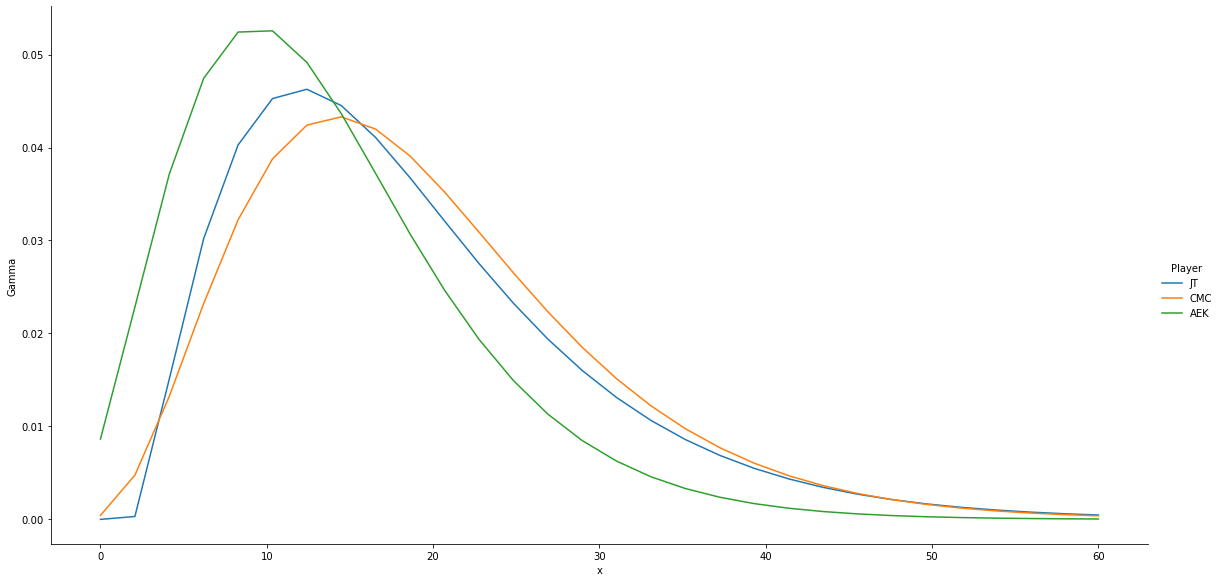

In [110]:
ax = sns.relplot(data=player_dist, x='x', y='Gamma', hue='Player', kind='line',height=8, aspect=2)

## Exploring Fantasy Point Distributions by Position

### Running Backs

In [19]:
rb = offense[offense['Pos'] == 'RB']

rb = rb.groupby('Player').mean().sort_values('HalfPPRFantasyPoints', ascending=False).HalfPPRFantasyPoints

rb_loc, rb_scale = norm.fit(rb)
print('rb_mu = {0}\trb_sigma = {1}'.format(rb_loc, rb_scale))

rb_cdf = norm.cdf(rb, loc=rb_loc, scale=rb_scale)

rb_mu = 5.217584028222668	rb_sigma = 4.2221949379947645


### Wide Receivers

In [20]:
wr = offense[offense['Pos'] == 'WR']

wr = wr.groupby('Player').mean().sort_values('HalfPPRFantasyPoints', ascending=False).HalfPPRFantasyPoints

wr_loc, wr_scale = norm.fit(wr)
print('wr_mu = {0}\twr_sigma = {1}'.format(wr_loc, wr_scale))

wr_cdf = norm.cdf(wr, loc=wr_loc, scale=wr_scale)

wr_mu = 5.008092750374201	wr_sigma = 3.7180591834708787


### Tight Ends

In [21]:
te = offense[offense['Pos'] == 'TE']

te = te.groupby('Player').mean().sort_values('HalfPPRFantasyPoints', ascending=False).HalfPPRFantasyPoints

te_loc, te_scale = norm.fit(te)
print('te_mu = {0}\tte_sigma = {1}'.format(te_loc, te_scale))

te_cdf = norm.cdf(te, loc=te_loc, scale=te_scale)

te_mu = 3.799134450625843	te_sigma = 2.8137226606670214


### Quarterbacks

In [22]:
qb = offense[offense['Pos'] == 'QB']

qb = qb.groupby('Player').mean().sort_values('HalfPPRFantasyPoints', ascending=False).HalfPPRFantasyPoints

qb_loc, qb_scale = norm.fit(qb)
print('qb_mu = {0}\tqb_sigma = {1}'.format(qb_loc, qb_scale))

qb_cdf = norm.cdf(qb, loc=qb_loc, scale=qb_scale)

qb_mu = 8.736287452053872	qb_sigma = 6.097459783919685


Text(0.5, 1.0, 'Cumulative Distribution Functions of Mean Fantasy Points across Positions from 2018-2021')

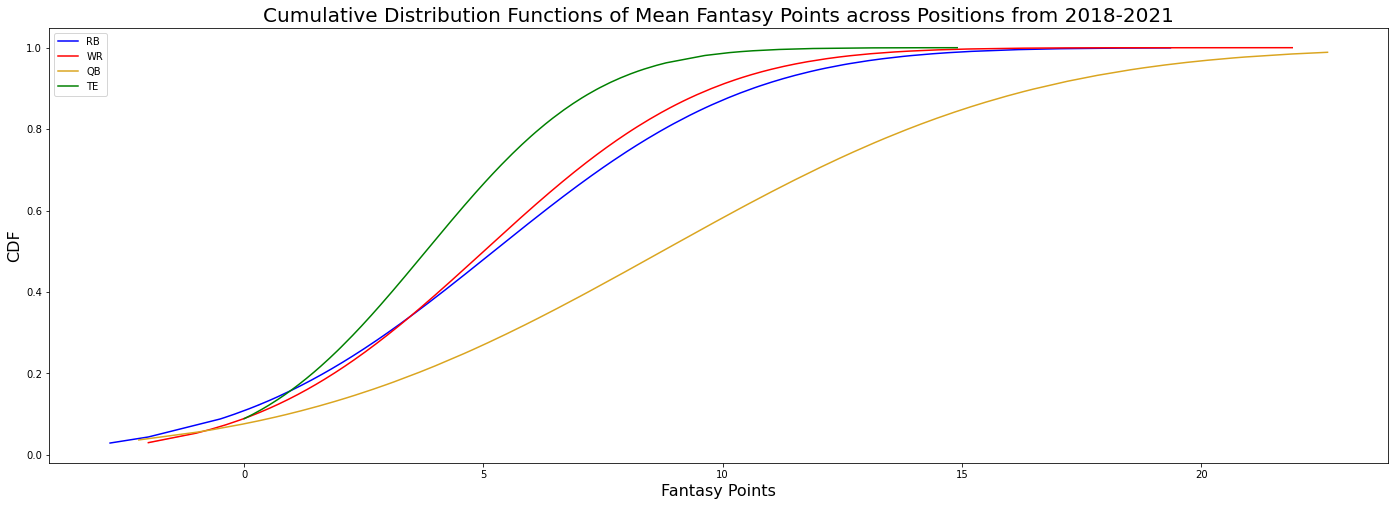

In [23]:
fig, ax = plt.subplots(1, figsize=(24,8))

sns.lineplot(x=rb, y=rb_cdf, ax=ax, color='blue', label='RB')
sns.lineplot(x=wr, y=wr_cdf, ax=ax, color='red', label='WR')
sns.lineplot(x=qb, y=qb_cdf, ax=ax, color='goldenrod', label='QB')
sns.lineplot(x=te, y=te_cdf, ax=ax, color='green', label='TE')

ax.legend(loc='upper left')
ax.set_xlabel('Fantasy Points', fontsize=16)
ax.set_ylabel('CDF', fontsize=16)
ax.set_title('Cumulative Distribution Functions of Mean Fantasy Points across Positions from 2018-2021', fontsize=20)